In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys

In [118]:
import shelve
import re
import nltk
import operator

In [86]:
from nltk.corpus import gutenberg as gb
from nltk.stem.porter import PorterStemmer

In [199]:
dt = open('npl_data/doc-text')
raw_text = dt.read()
dt.close()
split_text = re.split('[0-9]+\n',raw_text)

In [200]:
unwanted = set(nltk.corpus.stopwords.words("english"))
unwanted.update(list('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~£'))
unwanted.update(["''"])
unwanted.update(["``"])
unwanted.update(['""'])
porter_stemmer = PorterStemmer()

### Simple tf-idf

In [88]:
doc_terms = {}
term_index = {}
for k in range(1, len(split_text)):
    raw_tokens = nltk.word_tokenize(split_text[k])
    bigrams = nltk.bigrams(raw_tokens)
    fd_bi = nltk.FreqDist( (w1.lower(),w2.lower()) for w1,w2 in bigrams
        if not (w1.lower() in unwanted or w2.lower() in unwanted) )

    norm_tokens = [porter_stemmer.stem(x.lower()) for x in raw_tokens if x.lower() not in unwanted]
    doc_terms[k] = nltk.FreqDist(norm_tokens)
    for t in set(norm_tokens):
        if t.lower() not in term_index.keys():
            term_index[t.lower()] = set([k])
        else:
            term_index[t.lower()].add(k)

### N-gram tf-idf

In [204]:
print(split_text[1])

compact memories have flexible capacities  a digital data storage
system with capacity up to bits and random and or sequential access
is described
   /



In [210]:

for i in fd_bi:
    print(i)
    if i not in a.keys():
        a[i] = 1

('flexibl', 'capac')
('compact', 'memori')
('data', 'storag')
('storag', 'system')
('digit', 'data')
('sequenti', 'access')


In [211]:
print(a)

{('flexibl', 'capac'): 1, ('compact', 'memori'): 1, ('data', 'storag'): 1, ('storag', 'system'): 1, ('digit', 'data'): 1, ('sequenti', 'access'): 1}


[(('flexibl', 'capac'), 1), (('compact', 'memori'), 1), (('data', 'storag'), 1), (('storag', 'system'), 1), (('digit', 'data'), 1), (('sequenti', 'access'), 1)]


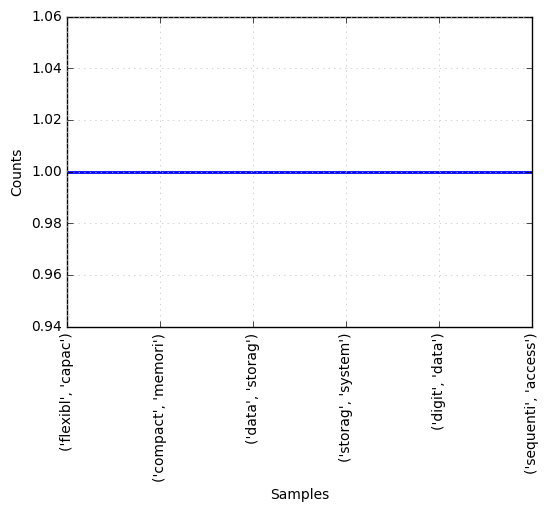

In [208]:
raw_tokens = nltk.word_tokenize(split_text[1])
bigrams = nltk.bigrams(raw_tokens)
fd_bi = nltk.FreqDist((porter_stemmer.stem(w1.lower()),porter_stemmer.stem(w2.lower())) for w1,w2 in bigrams
    if not (w1.lower() in unwanted or w2.lower() in unwanted) )


In [213]:
# N - gram TF_IDF
bi_doc_terms = {}
bi_term_index = {}
for k in range(1, len(split_text)):
    raw_tokens = nltk.word_tokenize(split_text[k])
    bigrams = nltk.bigrams(raw_tokens)
    bi_doc_terms[k] = nltk.FreqDist((porter_stemmer.stem(w1.lower()),porter_stemmer.stem(w2.lower())) 
                          for w1,w2 in bigrams
                           if not (w1.lower() in unwanted or w2.lower() in unwanted) )
    for t in bi_doc_terms[k]:
        if t not in bi_term_index.keys():
            bi_term_index[t] = set([k])
        else:
            bi_term_index[t].add(k)

### Search Queries Evaluation

In [232]:
# Reading query dataset 
dt = open('npl_data/query-text')
raw_text = dt.read()
dt.close()
q_text = re.split('[0-9]+\n',raw_text)
print(q_text[1])

MEASUREMENT OF DIELECTRIC CONSTANT OF LIQUIDS BY THE USE OF MICROWAVE TECHNIQUES
/



In [446]:
# Calcualting tf-idf for a query
def tfIdf_stem(split_text):
    results = []
    for q_id in range(len(split_text)):
        # Get tokens 
        raw_tokens = nltk.word_tokenize(split_text[q_id])
        # Filter stop words and use Porter stemmer
        norm_tokens = [porter_stemmer.stem(x.lower()) for x in raw_tokens if x.lower() not in unwanted]
        result = {}
        for term in norm_tokens:
            # Get idf
            
            if term not in term_index.keys():
                idf = 0
            else:
                idf = log(len(doc_terms)/len(term_index[term]))
                for t in term_index[term]:
                    tf = doc_terms[t][term]
                    if t not in result.keys():
                        result[t] = tf*idf
                    else:
                        # To calcualte for all query 
                        result[t] += tf*idf
            
            
        # Sort by tf-idf
        norm_results = [key for (key,value) in sorted(result.items(), reverse=True, key=operator.itemgetter(1))]
        tfidf_results = [value for (key,value) in sorted(result.items(), reverse=True, key=operator.itemgetter(1))]
        results.append((norm_results, tfidf_results))
    return results    

In [447]:
# Calculating bigram tf-idf for a query
def bi_tfIdf_stem(split_text):
    results = []
    for q_id in range(len(split_text)):
        # Get tokens 
        raw_tokens = nltk.word_tokenize(split_text[q_id])
        # Filter stop words and use Porter stemmer
        bigrams = nltk.bigrams(raw_tokens)
        norm_bigrams = nltk.FreqDist((porter_stemmer.stem(w1.lower()),porter_stemmer.stem(w2.lower())) 
                          for w1,w2 in bigrams
                           if not (w1.lower() in unwanted or w2.lower() in unwanted) )
        result = {}
        for term in norm_bigrams:
            # Get idf
            
            if term not in bi_term_index.keys():
                idf = 0
            else:
                idf = log(len(bi_doc_terms)/len(bi_term_index[term]))
                for t in bi_term_index[term]:
                    tf = bi_doc_terms[t][term]
                    if t not in result.keys():
                        result[t] = tf*idf
                    else:
                        # To calcualte for all query 
                        result[t] += tf*idf
            
            
        # Sort by tf-idf
        norm_results = [key for (key,value) in sorted(result.items(), reverse=True, key=operator.itemgetter(1))]
        tfidf_results = [value for (key,value) in sorted(result.items(), reverse=True, key=operator.itemgetter(1))]
        results.append((norm_results, tfidf_results))
    return results    

In [543]:
query_result = tfIdf_stem(q_text)


In [544]:
bi_query_result = bi_tfIdf_stem(q_text)

In [450]:
com_res = []
for i in range(len(q_text)):
    fin_result = {} 
    for k in range(len(bi_query_result[i][0])):
            key1 = bi_query_result[i][0][k]
            fin_result[key1] = bi_query_result[i][1][k]

    for k in range(len(query_result[i][0])):
            key1 = query_result[i][0][k]
            if key1 not in fin_result.keys():
                fin_result[key1] = query_result[i][1][k]
            else:
                fin_result[key1]+= query_result[i][1][k]

    combo_results = [key for (key,value) in sorted(fin_result.items(), reverse=True, key=operator.itemgetter(1))]
    com_res.append(combo_results)

In [451]:
bi_res = []
qu_res = []

for i_num in range(len(q_text)):
    b_res = [i for i in bi_query_result[i_num][0]]
    bi_res.append(b_res)
    q_res = [i for i in query_result[i_num][0]]
    qu_res.append(q_res)

In [452]:
def read_npl_eval():
    results = []
    dt = open('npl_data/rlv-ass')
    raw_text = dt.read()
    dt.close()
    s1 = re.split('\n', raw_text)
    indx = 0
    current_query = int(s1[indx])
    indx+=1
    query_docs = []
    while indx < len(s1):
        if '/' in s1[indx]:
        #BreakPoint
            indx+=1
            results.append(query_docs)
            query_docs = []
            continue
        s2 = s1[indx].split()
        for i in s2:
            query_docs.append(int(i))
        indx+=1
    return results

In [453]:
ground_true = read_npl_eval()

In [534]:
def simple_score(query_result, ground_true):
    scores = []
    for i in range(len(ground_true)):
        inter = set(ground_true[i]) & set(query_result[i+1][:len(ground_true)])
        prec = len(inter)/len(ground_true[i])
        scores.append(prec)
    return scores
        

In [529]:
def all_score(query_result, ground_true, fraction):
    f_scores = []
    for i in range(len(ground_true)):
        frac = int(fraction*len(query_result[i+1]))
        inter = set(ground_true[i]) & set(query_result[i+1][:frac])
        prec = len(inter)/len(query_result[i+1][:frac]) # precision 
        #print("Precision " + str(prec))
        recall = len(inter)/len(ground_true[i])
        #print("Recall " + str(recall))
        if prec+recall == 0: 
            F1_score = 0
        else:
            F1_score = 2*(prec*recall)/(prec+recall)
        f_scores.append(F1_score)
    return f_scores
    

In [547]:
np.mean(simple_score(com_res, ground_true))

0.45965402923852461

In [540]:
# Simple GridSearch

max_val = 0.0
max_index = 0
grid_max = 200

for i in range(1,grid_max):
        f_scores = all_score(com_res, ground_true, i/grid_max)
        new_val = np.mean(f_scores)
        if new_val > max_val:
            max_val = new_val
            max_index = i
print("Maximum F-score is " + str(max_val))
print("Best fraction to release " + str(max_index/grid_max))
        
        


Maximum F-score is 0.183543670708
Best fraction to release 0.015


### Conclusion and notes

The best result showed a combination of bi-gram tf-idf and simple tf-idf. 

Although, the difference between simple tf-idf and combination is not really sufficient  (0.442 vs 0.459)




One interesting observation: 
 

In [553]:
q_text[1]  # Original query

'MEASUREMENT OF DIELECTRIC CONSTANT OF LIQUIDS BY THE USE OF MICROWAVE TECHNIQUES\n/\n'

In [551]:
ground_true[0] # Ground true docs 

[1239,
 1502,
 4462,
 4569,
 5472,
 5502,
 6471,
 6480,
 6664,
 6824,
 7923,
 8150,
 8172,
 8277,
 9219,
 9859,
 9988,
 10081,
 10588]

Example doc 1239: 
broadband millimetre wave paramagnetic resonance spectrometer  the
specimen and waveguide which can be cooled by means of a cryostat
are placed between close pole pieces giving high uniform magnetic
fields  design details and some measurements on zero field splittings
are given

In [557]:
com_res[1][:19]

[3693,
 5502,
 7234,
 2236,
 1756,
 3994,
 11212,
 7734,
 1879,
 9859,
 7941,
 5039,
 8259,
 444,
 7923,
 7735,
 4569,
 4533,
 4571]

Example 3693:
electron interaction in solids  collective approach to the dielectric
constant  a quantum theory of the dielectric constant for solids
of both low and high polarizability is developed from first principles
in the latter case the approach used is collective in that the long
range part of the electron interaction is described by the plasmon
field  both the static and frequency dependent dielectric constant
are derived  it is shown that the interaction between electrons may
be described in terms of the dielectric constant of the solid provided
the electrons in question form a small minority group which can be
isolated from the much larger majority electron group

** Example 3693  contains the highest number of releavant to the query, i.e  dielectric constant is presented 4 times. But the example is irrelevant in general. **
